# Calculate SMB from SNOWPACK output

#### Author: Megan Thompson-Munson
#### Date created: 6 October 2021

Use this script to read in a ```*.smet``` file, which is the atmospheric output file from the SNOWPACK model, and calculate surface mass balance (SMB). SMB can be calculated from its components (e.g., snowfall, evaporation, etc.) and also from the change in snow water equivalent (SWE).

#### Input:
- One or multiple output ```*.smet``` files with path: ```/VIR<number>_<experiment>/VIR<number>_<experiment>.smet```

#### Output:
- Figure showing SMB, snowfall, rainfall, evaporation, sublimation, and runoff for all given files
- Figure comparing methods of calculating SMB (components vs. SWE) for all given files

## User input

In [1]:
# Location of folder(s) containing SNOWPACK output (.smet, .pro, etc.)
path = '/Users/metm9666/Dropbox/research/2021_TG-Michelle/'

# Select which stations to examine; can choose one or multiple
VIR = [2,3,5,6,9]

# SNOWPACK experiment name
exp = 'TG'

# Plot annual ('year') or monthly ('month') SMB and SMB components
freq = 'year'

# Date range (YYYY-MM-DD); leave blank quotes (e.g., '') for full record
start = '1980-01-01'
end = '2020-12-31'

# Type 'y' to save figures, 'n' to not save figures
savefig = 'n'

## End user input

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl

# Setting plotting parameters
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 10
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.default'] = 'regular'
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

## 1. Open and read files

### 1.1. Get information about variables and units

In [3]:
# .smet file path for any of the files
file = path+'VIR'+str(VIR[0])+'_'+exp+'/'+'VIR'+str(VIR[0])+'_'+exp+'.smet'

# Get variables, variable codes, and units from .smet header
dfVariables = pd.read_table(file, skiprows=9, nrows=8, delim_whitespace=True, header=None)
dfVariables.columns = np.array(dfVariables.iloc[5])
dfVariables = dfVariables.drop([2,3,5,6])
dfVariables = dfVariables.drop(columns=['='])
dfVariables.set_index('plot_description', inplace=True)

# Print variables and their abbreviations (note that temperature is actually degrees C)
for i in range(len(dfVariables.columns)):
    variable = np.array(dfVariables.columns)[i]
    abbreviation = np.array(dfVariables.loc['fields'].values)[i]
    unit = np.array(dfVariables.loc['plot_unit'].values)[i]
    print(variable+': '+abbreviation+' ('+unit+')')

timestamp: timestamp (-)
sensible_heat: Qs (W/m2)
latent_heat: Ql (W/m2)
ground_heat: Qg (W/m2)
ground_temperature: TSG (K)
ground_heat_at_soil_interface: Qg0 (W/m2)
rain_energy: Qr (W/m2)
melt_freeze_energy: Qmf (kJ/m2)
cold_content_snow: CCsnow (kJ/m2)
outgoing_long_wave_radiation: OLWR (W/m2)
incoming_long_wave_radiation: ILWR (W/m2)
net_long_wave_radiation: LWR_net (W/m2)
reflected_short_wave_radiation: OSWR (W/m2)
incoming_short_wave_radiation: ISWR (W/m2)
net_short_wave_radiation: Qw (W/m2)
parametrized_albedo: pAlbedo (-)
measured_albedo: mAlbedo (-)
incoming_short_wave_on_horizontal: ISWR_h (W/m2)
direct_incoming_short_wave: ISWR_dir (W/m2)
diffuse_incoming_short_wave: ISWR_diff (W/m2)
air_temperature: TA (K)
surface_temperature(mod): TSS_mod (K)
surface_temperature(meas): TSS_meas (K)
bottom_temperature: T_bottom (K)
relative_humidity: RH (-)
wind_velocity: VW (m/s)
wind_velocity_drift: VW_drift (m/s)
wind_direction: DW (°)
solid_precipitation_rate: MS_Snow (kg/m2/h)
snow_heig

### 1.2. Create dataframes of SMB components and calculate SMB

In [4]:
# Create empty lists for storing dataframes
dfs = []

# Loop through stations
for i in range(len(VIR)):
    
    # .smet file path
    file = path+'VIR'+str(VIR[i])+'_'+exp+'/'+'VIR'+str(VIR[i])+'_'+exp+'.smet'
    
    # Read in .smet file and get column names from dfVariables
    dfSmet = pd.read_table(file, skiprows=18, delim_whitespace=True, names=np.array(dfVariables.iloc[3]))
    
    # Turn timestamp into pandas datetime and get relevant columns from dataframe
    dfSmet['Timestamp'] = pd.to_datetime(dfSmet.timestamp)
    dfSmet = dfSmet[['Timestamp','MS_Snow','MS_Wind','MS_Rain','MS_Evap','MS_Sublimation','MS_SN_Runoff','SWE']]
    
    # Some variables (e.g., MS_Snow) need to be converted from rates so get time change in hours
    dfSmet['dt'] = (dfSmet.Timestamp-dfSmet.Timestamp.shift()).dt.total_seconds()/3600
    
    # Calculate snowfall and rainfall as kg/m^2 rather than kg/m^2/hr. Need to subtract wind from snow.
    dfSmet['Snowfall'] = (dfSmet.MS_Snow-dfSmet.MS_Wind)*dfSmet.dt
    dfSmet['Rainfall'] = dfSmet.MS_Rain*dfSmet.dt
    
    # Calculate SMB
    dfSmet['SMB'] = dfSmet.Snowfall + dfSmet.Rainfall + dfSmet.MS_Evap + dfSmet.MS_Sublimation - dfSmet.MS_SN_Runoff
    
    # Calculate change in SWE (which is essentially SMB)
    dSWE = np.array(dfSmet.SWE)[1:] - np.array(dfSmet.SWE)[:-1]
    dSWE = np.insert(dSWE,0,0)
    dfSmet['dSWE'] = dSWE
    
    # Set timestamp as index
    dfSmet.set_index('Timestamp',inplace=True)
    
    # Extract only necessary columns from the dataframe
    dfSmet = dfSmet[['Snowfall','Rainfall','MS_Evap','MS_Sublimation','MS_SN_Runoff','dSWE','SMB']]
    
    # If start and end date are given, crop the dataframe to desired time period
    if len(start) > 0:
        
        # Convert strings to pandas datetimes
        startTimestamp = pd.to_datetime(start)
        endTimestamp = pd.to_datetime(end)
        
        # Apply start/end conditions to dataframe
        dfSmet = dfSmet[dfSmet.index>=startTimestamp]
        dfSmet = dfSmet[dfSmet.index<=endTimestamp]
    
    # Store dataframes in list
    dfs.append(dfSmet)

# View one dataframe to make sure it looks okay
dfs[0]

,Snowfall,Rainfall,MS_Evap,MS_Sublimation,MS_SN_Runoff,dSWE,SMB
Timestamp,,,,,,,
1980-01-01 01:30:00,NaN,NaN,0.000,-0.019,0.0,0.000,NaN
1980-01-01 12:00:00,0.000,0.0,0.000,-0.261,0.0,-0.261,-0.261
1980-01-02 12:00:00,2.136,0.0,0.000,-0.465,0.0,1.679,1.671
1980-01-03 12:00:00,1.920,0.0,-0.167,-0.195,0.0,1.547,1.558
1980-01-04 12:00:00,16.320,0.0,0.000,-1.160,0.0,15.144,15.160
...,...,...,...,...,...,...,...
2020-12-26 12:00:00,0.000,0.0,0.000,-1.035,0.0,-1.036,-1.035
2020-12-27 12:00:00,0.096,0.0,0.000,-0.323,0.0,-0.238,-0.227
2020-12-28 12:00:00,0.432,0.0,0.000,-0.112,0.0,0.313,0.320


## 2. Plot figures

### 2.1. SMB from components

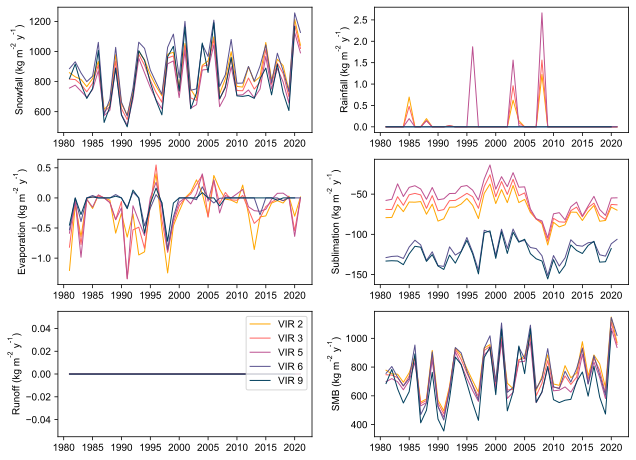

In [5]:
# Create figure for plotting
fig, ax = plt.subplots(3,2,figsize=(9,6.5))
fig.patch.set_facecolor('#FFFFFF')

# Create list of colors
colors = ['#ffa600','#ff6361','#bc5090','#58508d','#003f5c']

# Set axes based on month or year
if freq == 'month':
    ax[0,0].set_ylabel('Snowfall (kg m$^{-2}$ month$^{-1}$)')
    ax[0,1].set_ylabel('Rainfall (kg m$^{-2}$ month$^{-1}$)')
    ax[1,0].set_ylabel('Evaporation (kg m$^{-2}$ month$^{-1}$)')
    ax[1,1].set_ylabel('Sublimation (kg m$^{-2}$ month$^{-1}$)')
    ax[2,0].set_ylabel('Runoff (kg m$^{-2}$ month$^{-1}$)')
    ax[2,1].set_ylabel('SMB (kg m$^{-2}$ month$^{-1}$)')
if freq == 'year':
    ax[0,0].set_ylabel('Snowfall (kg m$^{-2}$ y$^{-1}$)')
    ax[0,1].set_ylabel('Rainfall (kg m$^{-2}$ y$^{-1}$)')
    ax[1,0].set_ylabel('Evaporation (kg m$^{-2}$ y$^{-1}$)')
    ax[1,1].set_ylabel('Sublimation (kg m$^{-2}$ y$^{-1}$)')
    ax[2,0].set_ylabel('Runoff (kg m$^{-2}$ y$^{-1}$)')
    ax[2,1].set_ylabel('SMB (kg m$^{-2}$ y$^{-1}$)')

# Loop through stations
for i in range(len(VIR)):
    
    # Extract dataframe from list
    dfSmet = dfs[i]
    
    # Calculate annual and monthly sums
    dfSmetAnnual = dfSmet.resample('y').sum()
    dfSmetMonthly = dfSmet.resample('m').sum()
    
    ### Monthly SMB ###
    if freq == 'month':
        
        ax[0,0].plot(dfSmetMonthly.Snowfall,lw=1,color=colors[i])
        ax[0,1].plot(dfSmetMonthly.Rainfall,lw=1,color=colors[i])
        ax[1,0].plot(dfSmetMonthly.MS_Evap,lw=1,color=colors[i])
        ax[1,1].plot(dfSmetMonthly.MS_Sublimation,lw=1,color=colors[i])
        ax[2,0].plot(dfSmetMonthly.MS_SN_Runoff,lw=1,color=colors[i],label='VIR '+str(VIR[i]))
        ax[2,1].plot(dfSmetMonthly.SMB,lw=1,color=colors[i])
    
        ax[2,0].legend()
        
    ### Annual SMB ###
    if freq == 'year':
        
        ax[0,0].plot(dfSmetAnnual.Snowfall,lw=1,color=colors[i])
        ax[0,1].plot(dfSmetAnnual.Rainfall,lw=1,color=colors[i])
        ax[1,0].plot(dfSmetAnnual.MS_Evap,lw=1,color=colors[i])
        ax[1,1].plot(dfSmetAnnual.MS_Sublimation,lw=1,color=colors[i])
        ax[2,0].plot(dfSmetAnnual.MS_SN_Runoff,lw=1,color=colors[i],label='VIR '+str(VIR[i]))
        ax[2,1].plot(dfSmetAnnual.SMB,lw=1,color=colors[i])
    
        ax[2,0].legend()
        
    plt.tight_layout()

if savefig == 'y':
    plt.savefig(path+'SMB_components.png',dpi=500)

### 2.2. SMB from SWE vs components

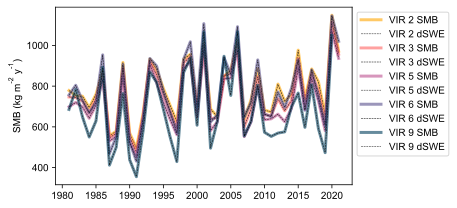

In [6]:
# Create figure for plotting
fig, ax = plt.subplots(1,figsize=(6.5,3))
fig.patch.set_facecolor('#FFFFFF')

# Create list of colors
colors = ['#ffa600','#ff6361','#bc5090','#58508d','#003f5c']

# Set axes based on month or year
if freq == 'month':
    ax.set_ylabel('SMB (kg m$^{-2}$ month$^{-1}$)')
if freq == 'year':
    ax.set_ylabel('SMB (kg m$^{-2}$ y$^{-1}$)')

# Loop through stations
for i in range(len(VIR)):
    
    # Extract dataframe from list
    dfSmet = dfs[i]
    
    # Calculate annual and monthly sums
    dfSmetAnnual = dfSmet.resample('y').sum()
    dfSmetMonthly = dfSmet.resample('m').sum()
    
    ### Monthly SMB ###
    if freq == 'month':
        ax.plot(dfSmetMonthly.SMB,lw=3,color=colors[i],alpha=0.6,label='VIR '+str(VIR[i])+' SMB')
        ax.plot(dfSmetMonthly.dSWE,lw=0.5,color='k',ls='--',label='VIR '+str(VIR[i])+' dSWE')
    
        ax.legend(bbox_to_anchor=(1,1),loc='upper left')
        
    ### Annual SMB ###
    if freq == 'year':
        ax.plot(dfSmetAnnual.SMB,lw=3,color=colors[i],alpha=0.6,label='VIR '+str(VIR[i])+' SMB')
        ax.plot(dfSmetAnnual.dSWE,lw=0.5,color='k',ls='--',label='VIR '+str(VIR[i])+' dSWE')
    
        ax.legend(bbox_to_anchor=(1,1),loc='upper left')

plt.tight_layout()

if savefig == 'y':
    plt.savefig(path+'SMB_dSWE.png',dpi=500)